Este código foi escrito em razão da minha dissertação de mestrado e é parte integrante da mesma. 

Nele é realizada a previsão de pedidos de uma empresa de food delivery para o centro expandido da cidade de São Paulo- SP com as técnicas Spatial Autorregressive Model (SAR) e Rede Neurais Artificiais Multilayer Perceptron (MLP).

# Modelos de regressão espacial aplicados à previsão de demanda de Online Food Delivery
### Spatial Regression Models applied to Orders Demand Forecasting of Online Food Delivery

## Índice

0. [Importando bibliotecas necessárias](#bibliotecas)

1. Leitura e manipulação dos arquivos com geodados de SP e dos pedidos
    - [Lendo o arquivo dos polígonos dos distritos de SP](#lendo-poligonos)
    - [Leitura da base de dados de pedidos em SP](#sec01)
    
2. Relendo arquivos tratados e criando dataframe para modelagem 
    - [Relendo arquivos tratados de geometrias e pedidos](#releitura)
    - [Analise exploratória - Pedidos ](#exploratoria)
    - [Calculando medidas de de autocorrelação espacial](#autocorr)
    - [Criando dataframe de modelagem e variáveis necessárias](#criandodfmodelagem)

3. Ajustes dos modelos e métricas de avaliação
    - [Ajuste do modelo SAR](#ajuste-sar)
    - [Métricas de desempenho SAR](#metricas-sar)
    - [Ajuste do modelo RNA MLP](#ajuste-mlp)
    - [Métricas de desempenho MLP](#metricas-mlp)


4. [Previsão para o dia 15-10-2019](#prev-15-10-2019)

---

### Importando bibliotecas necessárias <a name="bibliotecas"></a>

In [308]:
from seaborn import palplot, countplot, barplot, boxplot, lineplot, kdeplot
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely as shp
import adjustText as aT
import numpy as np
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

from pysal.lib import weights
from pysal.explore import esda

from splot.esda import plot_moran

from pysal.model import spreg

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid

from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [602]:
from sklearn import __version__ as versao_sklearn

---

### Lendo o arquivo dos polígonos dos distritos de SP <a name="lendo-poligonos"></a>

In [4]:
distritos = gpd.read_file("Distritos SP/DEINFO_DISTRITO.shp", crs={'init':'epsg:4291'})

In [5]:
distritos.crs

{'proj': 'utm',
 'zone': 23,
 'south': True,
 'ellps': 'aust_SA',
 'units': 'm',
 'no_defs': True}

In [6]:
distritos=distritos.to_crs(epsg=4326)

C:\Users\Herlisson\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [7]:
distritos.shape

(96, 10)

In [8]:
distritos.head()

,CLASSID,FEATID,REVISIONNU,NOME_DIST,SIGLA_DIST,COD_DIST,COD_SUB,DATA_CRIAC,USUARIO_ID,geometry
0,4.0,8583485.0,1.0,JOSE BONIFACIO,JBO,47,27,2007-03-19,0.0,"POLYGON ((-46.44578 -23.55602, -46.44564 -23.5..."
1,4.0,8583484.0,1.0,JD SAO LUIS,JDS,46,18,2007-03-19,0.0,"POLYGON ((-46.75793 -23.64810, -46.75790 -23.6..."
2,4.0,8583445.0,1.0,ARTUR ALVIM,AAL,5,21,2007-03-19,0.0,"POLYGON ((-46.47456 -23.52332, -46.47456 -23.5..."
3,4.0,8583479.0,1.0,JAGUARA,JAG,40,08,2007-03-19,0.0,"POLYGON ((-46.75555 -23.49467, -46.75554 -23.4..."
4,4.0,8583437.0,1.0,VILA PRUDENTE,VPR,93,29,2007-03-19,0.0,"POLYGON ((-46.58102 -23.57250, -46.58099 -23.5..."


<AxesSubplot:>

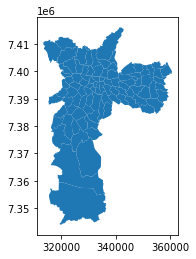

In [364]:
distritos.plot()

C:\Users\Herlisson\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

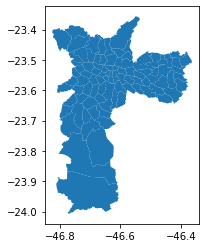

In [9]:
distritos.to_crs(epsg=4326).plot()

In [12]:
distritos['NOME_DIST'].unique()

array(['JOSE BONIFACIO', 'JD SAO LUIS', 'ARTUR ALVIM', 'JAGUARA',
       'VILA PRUDENTE', 'JAGUARE', 'JARAGUA', 'JD HELENA', 'JD PAULISTA',
       'LAJEADO', 'LAPA', 'LIBERDADE', 'LIMAO', 'VILA MEDEIROS',
       'JD ANGELA', 'PARELHEIROS', 'VILA SONIA', 'AGUA RASA',
       'ALTO DE PINHEIROS', 'ANHANGUERA', 'ARICANDUVA', 'BARRA FUNDA',
       'BELA VISTA', 'BELEM', 'BOM RETIRO', 'BRAS', 'BRASILANDIA',
       'BUTANTA', 'CACHOEIRINHA', 'CAMBUCI', 'CAMPO BELO', 'CAMPO GRANDE',
       'CAMPO LIMPO', 'CANGAIBA', 'CAPAO REDONDO', 'CARRAO', 'CASA VERDE',
       'CID ADEMAR', 'CID DUTRA', 'CID LIDER', 'CID TIRADENTES',
       'CONSOLACAO', 'CURSINO', 'ERMELINO MATARAZZO', 'FREGUESIA DO O',
       'GRAJAU', 'GUAIANASES', 'IGUATEMI', 'IPIRANGA', 'ITAIM BIBI',
       'ITAIM PAULISTA', 'ITAQUERA', 'JABAQUARA', 'JACANA', 'MANDAQUI',
       'MARSILAC', 'MOEMA', 'MOOCA', 'MORUMBI', 'PARI', 'PARQUE DO CARMO',
       'PEDREIRA', 'PENHA', 'PERDIZES', 'PERUS', 'PINHEIROS', 'PIRITUBA',
       'PONTE RASA

In [9]:
#Distritos que fazem parte completamente do centro expandido , mais Itaim Bibi.
centro_expandido = [
    'VILA LEOPOLDINA' ,
    'LAPA' ,
    'BARRA FUNDA' ,
    'PERDIZES' ,
    
    'ALTO DE PINHEIROS' ,
    'PINHEIROS' ,
    'JD PAULISTA' ,
    'ITAIM BIBI',
    
    'MOEMA' ,
    'VILA MARIANA' ,
    'SAUDE' ,
    
    'BOM RETIRO' ,
    'SANTA CECILIA' ,
    'CONSOLACAO' ,
    'BELA VISTA' ,
    'LIBERDADE' ,
    'SE' ,
    'REPUBLICA' ,
    'CAMBUCI' ,
    
    'PARI' ,
    'BRAS' ,
    'BELEM' ,
    'MOOCA' ,
    
    'IPIRANGA'
]

In [10]:
len(centro_expandido)

24

In [12]:
distritos_ce = distritos[distritos['NOME_DIST'].isin(centro_expandido)][['NOME_DIST','geometry']].to_crs(epsg=4326)

C:\Users\Herlisson\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [13]:
distritos_ce.shape

(24, 2)

<AxesSubplot:>

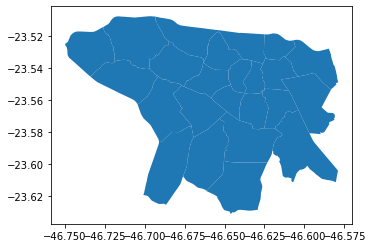

In [14]:
distritos_ce.plot()

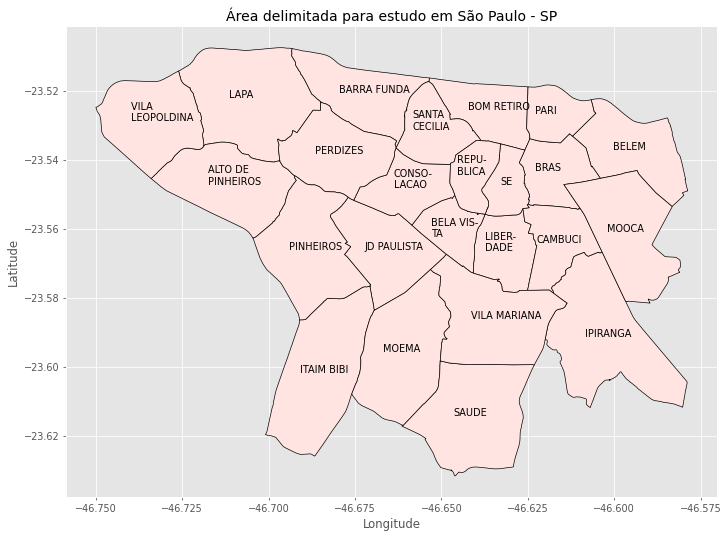

In [70]:
distritos_ce["rep"] = distritos_ce["geometry"].centroid
distritos_ce2 = distritos_ce.copy()
distritos_ce2.set_geometry("rep", inplace = True)

fig = figure(figsize=(12,12), dpi=70)
ax = plt.axes()

distritos_ce2.plot(figsize = (15, 12), color = "blue", edgecolor = "lightgrey", linewidth = 0.5, ax=ax)
distritos_ce.plot(figsize = (15, 12), color = "mistyrose", edgecolor = "black", linewidth = 0.7, ax=ax)
texts = []

for x, y, label in zip(distritos_ce2.geometry.x, distritos_ce2.geometry.y, distritos_ce2["NOME_DIST"]):
    if label =='SE':
        texts.append(plt.text(x-0.002, y, label, fontsize = 10))
    elif label =='REPUBLICA':
        label = 'REPU-\nBLICA'
        texts.append(plt.text(x-0.005, y, label, fontsize = 10))
    elif label =='VILA LEOPOLDINA':
        label = 'VILA \nLEOPOLDINA'
        texts.append(plt.text(x-0.006, y, label, fontsize = 10))
    elif label =='ALTO DE PINHEIROS':
        label = 'ALTO DE\nPINHEIROS'
        texts.append(plt.text(x-0.006, y, label, fontsize = 10))
    elif label =='SANTA CECILIA':
        label = 'SANTA\nCECILIA'
        texts.append(plt.text(x-0.006, y, label, fontsize = 10))
    elif label =='CONSOLACAO':
        label = 'CONSO-\nLACAO'
        texts.append(plt.text(x-0.004, y, label, fontsize = 10))
    elif label =='BELA VISTA':
        label = 'BELA VIS-\nTA'
        texts.append(plt.text(x-0.006, y-0.002, label, fontsize = 10))
    elif label =='LIBERDADE':
        label = 'LIBER-\nDADE'
        texts.append(plt.text(x-0.006, y, label, fontsize = 10))
    else:
        texts.append(plt.text(x-0.006, y, label, fontsize = 10))
        
ax.set_title("Área delimitada para estudo em São Paulo - SP")
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

plt.savefig('figura_area_estudo_sp.png' , bbox_inches='tight')
plt.show()
#aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
               #arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

In [67]:
distritos_ce.to_csv('distritos_centro_expandido_sp.csv' , index=False)

---

## Leitura do arquivo de pedidos <a name="sec01"></a>

Lendo o arquivo com os pedidos realizados em toda a cidade de São Paulo - SP para agregar com qual região o pedido foi feito

In [368]:
pedidos = pd.read_csv("pedidos_sp.csv")

In [369]:
pedidos.shape

(81810, 50)

In [370]:
pedidos.head()

,Unnamed: 0,order_id,order_number,order_timestamp_local,order_shift,last_status_date_local,order_total,credit,paid_amount,delivery_type,...,order_date_local,valid_order,session_id,customer_id,order_month_day,order_weekday,order_month,order_date,customer_latitude,customer_longitude
0,2,e8c55557-81d4-4159-bd2b-c144e5fbabe3,694742752,2019-06-11 20:42:32.058000+00:00,weekday dinner,2019-06-11T22:42:54.005Z,53.8,4.0,49.8,DELIVERY,...,2019-06-11T00:00:00.000Z,1,035b33cd-6ddf-4ee2-a887-7ba490bb9700,c4f8999d4cb83cac8134b2051ffc611d5d660c049c3744...,11,1,6,2019-06-11,-23.64,-46.59
1,4,998f6d97-f884-40ba-a7a3-e9691930a642,1052187003,2019-10-15 21:01:23.973000+00:00,weekday dinner,2019-10-15T23:01:41.146Z,54.8,14.0,50.8,DELIVERY,...,2019-10-15T00:00:00.000Z,1,515a402d-8b86-4e6d-9852-f02282736781,fdef6bf0530b1f6507f175167aa442ade79b6e6fa085c9...,15,1,10,2019-10-15,-23.45,-46.73
2,13,4511884b-ac72-44c2-9321-eb59e93dca45,690050151,2019-06-10 00:41:14.558000+00:00,weekend dawn,2019-06-10T06:48:56.869Z,46.8,4.0,42.8,DELIVERY,...,2019-06-10T00:00:00.000Z,1,4e0bfb70-5bde-4f74-8865-c67c83012c76,6cf18243f88c0e11fbd53d802282b299e76def34285cf8...,10,0,6,2019-06-10,-23.60,-46.65
3,20,e549a902-517c-495f-813d-456ec4d4033f,977624842,2019-09-25 20:05:11.830000+00:00,weekday dinner,2019-09-25T22:06:06.277Z,25.0,4.0,21.0,DELIVERY,...,2019-09-25T00:00:00.000Z,1,69abf615-df30-4519-9b6d-3ccd3411d400,45b8ce14a552f747873f76bfd5df5454ab5a285fbe9f0a...,25,2,9,2019-09-25,-23.47,-46.66
4,22,8c062ba1-b30f-42ff-ab80-914a1df4446a,780756938,2019-07-16 12:03:28.002000+00:00,weekday lunch,2019-07-16T12:40:17.416Z,28.6,12.0,16.6,DELIVERY,...,2019-07-16T00:00:00.000Z,1,6f957f27-89a3-4847-8880-b86681c8f761,4311cabf116b98af5288a4e67b08d4cd3a7fa8bcc9b51c...,16,1,7,2019-07-16,-23.57,-46.67


In [60]:
pedidos.columns

Index(['Unnamed: 0', 'order_id', 'order_number', 'order_timestamp_local',
       'order_shift', 'last_status_date_local', 'order_total', 'credit',
       'paid_amount', 'delivery_type', 'scheduled',
       'scheduled_creation_date_local', 'device_app_version', 'device_type',
       'device_platform', 'payment_method', 'customer_state_label',
       'customer_city', 'customer_district', 'customer_centroid_id',
       'customer_has_plus', 'customer_seg_status_last_month',
       'customer_seg_recency_bucket', 'customer_seg_frequency_bucket',
       'customer_seg_merchant_offer_bucket',
       'customer_seg_benefits_sensitivity_bucket', 'customer_seg_marlin_tag',
       'customer_seg_gross_income_bucket', 'customer_seg_preferred_shift',
       'frn_id', 'merchant_city', 'merchant_district', 'merchant_centroid_id',
       'merchant_dish_type', 'distance_merchant_customer',
       'promo_is_promotion', 'normal_items_quantity', 'promo_items_quantity',
       'order_lag_at_login', 'order_lead

In [61]:
pd.to_datetime(pedidos['order_timestamp_local']).min()

Timestamp('2019-06-01 00:00:15.369000+0000', tz='UTC')

In [62]:
pd.to_datetime(pedidos['order_timestamp_local']).max()

Timestamp('2019-12-31 22:54:42.278000+0000', tz='UTC')

 - Criando uma coluna com as inforamações da lat e long do cliente que fez o pedido com objetos do Shapely para que o Geodataframe seja criado sem problemas

In [371]:
pedidos['pontos'] = [ shp.geometry.Point(x,y) for x , y in zip( pedidos['customer_longitude'] , pedidos['customer_latitude'] ) ]

- Mantendo apenas as variáveis que fazem sentido para a previsão dos pedidos, pois as outras são informações que só se obtém quando o pedido é encerrado.

In [372]:
#Variaveis para manter na base de dados final
keep = ['order_timestamp_local', 'order_shift' , 'order_weekday', 'order_month','order_date', 'customer_longitude' , 'customer_latitude', 'pontos']

In [373]:
pedidos2 = pedidos[ keep ]
print( pedidos2.shape )
pedidos2.head()

(81810, 8)


,order_timestamp_local,order_shift,order_weekday,order_month,order_date,customer_longitude,customer_latitude,pontos
0,2019-06-11 20:42:32.058000+00:00,weekday dinner,1,6,2019-06-11,-46.59,-23.64,POINT (-46.59 -23.64)
1,2019-10-15 21:01:23.973000+00:00,weekday dinner,1,10,2019-10-15,-46.73,-23.45,POINT (-46.73 -23.45)
2,2019-06-10 00:41:14.558000+00:00,weekend dawn,0,6,2019-06-10,-46.65,-23.60,POINT (-46.65 -23.6)
3,2019-09-25 20:05:11.830000+00:00,weekday dinner,2,9,2019-09-25,-46.66,-23.47,POINT (-46.66 -23.47)
4,2019-07-16 12:03:28.002000+00:00,weekday lunch,1,7,2019-07-16,-46.67,-23.57,POINT (-46.67 -23.57)


 - Montando a base final com cada pedido realizado dentro de centro expandido , junto com a marcação de cada distrito por pedido

In [141]:
pedidos_geo = gpd.GeoDataFrame(pedidos2 , geometry = 'pontos')

pedidos_final  = gpd.sjoin(pedidos_geo, distritos_ce,  how= 'inner' ).reset_index(drop = True)
pedidos_final['data'] = pd.to_datetime(pedidos_final['order_timestamp_local']).dt.date

C:\Users\Herlisson\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [142]:
pedidos_final.head()

,order_timestamp_local,order_shift,order_weekday,order_month,order_date,customer_longitude,customer_latitude,pontos,index_right,NOME_DIST,rep,data
0,2019-06-10 00:41:14.558000+00:00,weekend dawn,0,6,2019-06-10,-46.65,-23.60,POINT (-46.65000 -23.60000),79,SAUDE,POINT (-46.64062 -23.61412),2019-06-10
1,2019-09-24 13:32:57.191000+00:00,weekday lunch,1,9,2019-09-24,-46.64,-23.62,POINT (-46.64000 -23.62000),79,SAUDE,POINT (-46.64062 -23.61412),2019-09-24
2,2019-06-05 11:50:00+00:00,weekday lunch,2,6,2019-06-05,-46.65,-23.61,POINT (-46.65000 -23.61000),79,SAUDE,POINT (-46.64062 -23.61412),2019-06-05
3,2019-12-26 22:16:24.668000+00:00,weekday dinner,3,12,2019-12-26,-46.64,-23.62,POINT (-46.64000 -23.62000),79,SAUDE,POINT (-46.64062 -23.61412),2019-12-26
4,2019-12-12 13:21:46.332000+00:00,weekday lunch,3,12,2019-12-12,-46.64,-23.60,POINT (-46.64000 -23.60000),79,SAUDE,POINT (-46.64062 -23.61412),2019-12-12


In [130]:
pedidos_final.to_csv('pedidos_final_ce_sp.csv' , index=False)

---
### Relendo arquivos tratados de geometrias e pedidos para continuar <a name="releitura"></a>

In [6]:
distritos_ce = pd.read_csv('distritos_centro_expandido_sp.csv')
distritos_ce['geometry']=distritos_ce['geometry'].apply( shp.wkt.loads )
distritos_ce = gpd.GeoDataFrame( distritos_ce , geometry='geometry')

In [7]:
#Lendo o arquivo novamente para continuar
pedidos_final =  pd.read_csv('pedidos_final_ce_sp.csv')
pedidos_final['pontos'] = [ shp.geometry.Point(x,y) for x , y in zip( pedidos_final['customer_longitude'] , pedidos_final['customer_latitude'] ) ]
pedidos_final['data'] = pd.to_datetime(pedidos_final['order_timestamp_local']).dt.date.astype('datetime64')
pedidos_final = gpd.GeoDataFrame(pedidos_final , geometry = 'pontos')

pedidos_final_agg = pedidos_final.groupby(['NOME_DIST', 'data','order_weekday' , 'order_month']) \
            .count()['order_timestamp_local'].reset_index() \
            .rename(columns= {'order_timestamp_local':'count_orders'})

In [8]:
pedidos_final.shape

(36135, 12)

In [9]:
resumo = pedidos_final_agg.groupby('NOME_DIST').agg( {'count_orders': ['count','sum', 'min', 'median', 'mean', 'max', 'std']})

---
### Analise exploratória - Pedidos <a name="exploratoria"></a>

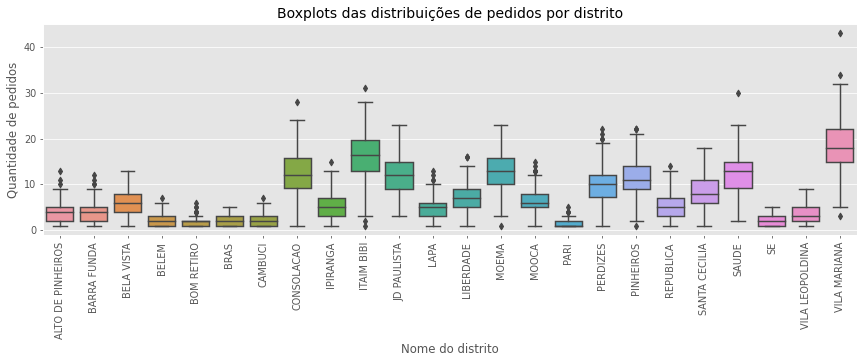

In [38]:
#Plotando o boxplot com as distribuições de pedidos por distrito
figure(figsize=(15,4), dpi=70)
ax = plt.axes()
fig = sns.boxplot( x = 'NOME_DIST', y ='count_orders', data= pedidos_final_agg  )
fig.set_xlabel('Nome do distrito')
fig.set_ylabel('Quantidade de pedidos')
fig.set_title('Boxplots das distribuições de pedidos por distrito')
ax.tick_params(axis='x', rotation=90)

plt.savefig('figura_boxplots.png' , bbox_inches='tight')

plt.show()



In [14]:
distritos_ce.merge( resumo[[('count_orders','sum'),('count_orders','mean')]], how = 'left' , left_on ='NOME_DIST', right_index=True ).rename(columns={('count_orders', 'sum'):"sum" , ('count_orders', 'mean'):"mean" })

C:\Users\Herlisson\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,NOME_DIST,geometry,sum,mean
0,JD PAULISTA,"POLYGON ((-46.66934 -23.58349, -46.66939 -23.5...",2552,11.925234
1,LAPA,"POLYGON ((-46.71895 -23.53618, -46.71878 -23.5...",1021,4.816038
2,LIBERDADE,"POLYGON ((-46.63738 -23.55575, -46.63709 -23.5...",1476,6.897196
3,ALTO DE PINHEIROS,"POLYGON ((-46.71895 -23.53618, -46.71886 -23.5...",810,3.913043
4,BARRA FUNDA,"POLYGON ((-46.68931 -23.50854, -46.68921 -23.5...",834,3.990431
5,BELA VISTA,"POLYGON ((-46.64856 -23.56733, -46.64862 -23.5...",1271,6.052381
6,BELEM,"POLYGON ((-46.57873 -23.54892, -46.57876 -23.5...",343,2.117284
7,BOM RETIRO,"POLYGON ((-46.65346 -23.51630, -46.65251 -23.5...",267,1.867133
8,BRAS,"POLYGON ((-46.60978 -23.55415, -46.61035 -23.5...",316,1.962733
9,CAMBUCI,"POLYGON ((-46.61759 -23.57857, -46.61767 -23.5...",339,2.005917


C:\Users\Herlisson\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Mapa cloroplético dos pedidos por distrito')

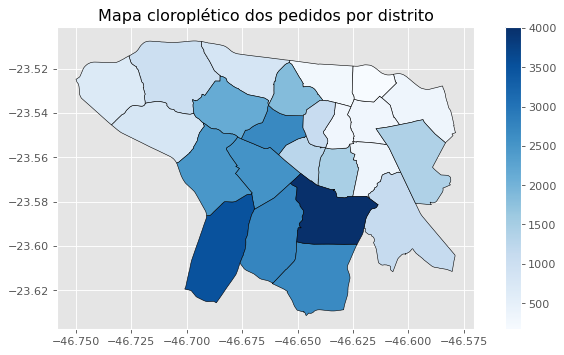

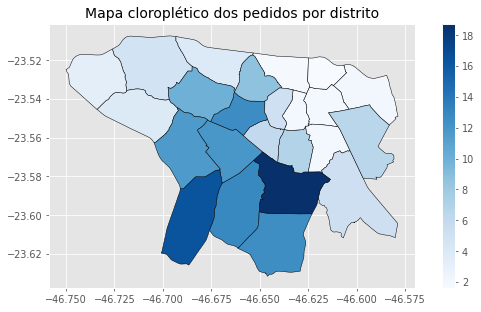

In [21]:
distritos2 = distritos_ce.merge( resumo[[('count_orders','sum'),('count_orders','mean')]], how = 'left' , left_on ='NOME_DIST', right_index=True ).rename(columns={('count_orders', 'sum'):"sum" , ('count_orders', 'mean'):"mean" })

figure(figsize=(10,5), dpi=80)
ax = plt.axes()
distritos2.plot(column='sum',legend=True , ax=ax , cmap='Blues', edgecolor='black')
ax.set_title('Mapa cloroplético dos pedidos por distrito')

plt.savefig('figura_pedidos_por_distrito.png' , bbox_inches='tight')

figure(figsize=(10,5), dpi=70)
ax = plt.axes()
distritos2.plot(column='mean',legend=True , ax=ax , cmap='Blues', edgecolor='black')
ax.set_title('Mapa cloroplético dos pedidos por distrito')

---
#### Grafico de tendência dos pedidos ao longo do tempo

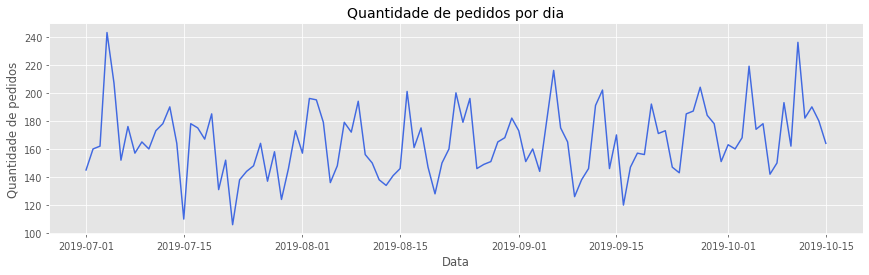

In [32]:
figure(figsize=(15,4), dpi=70)
filtro_data = (pedidos_final_agg['data'] >='2019-07-01') & (pedidos_final_agg['data'] <='2019-10-15')
ax = sns.lineplot(y='count_orders', x= 'data', data= pedidos_final_agg[filtro_data], ci = None, estimator='sum' , color='royalblue')
ax.title.set_text("Quantidade de pedidos por dia")
ax.set_ylabel("Quantidade de pedidos")
ax.set_xlabel("Data")

plt.savefig('figura_serie_pedidos_diarios.png' , bbox_inches='tight')

plt.show()

#### Aplicacao do teste de tendência Mann-Kendall

In [20]:
import pymannkendall as mk

In [27]:
mk.original_test( pedidos_final_agg[filtro_data].groupby('data')['count_orders'].sum().values )

Mann_Kendall_Test(trend='no trend', h=False, p=0.08098629130725632, z=1.7449918289064177, Tau=0.11444189737259743, s=649.0, var_s=137899.66666666666, slope=0.13580246913580246, intercept=156.80246913580248)



Considerando um nível de significância de 5%, o p-valor = 8.09% não permite rejeitar a hipótese nula do teste que diz que os dados não possuem tendência.



---
#### Calculando medida de de autocorrelação espacial de Moran - Centro expandido <a name="autocorr"></a>

In [54]:
distritos_ce = distritos_ce.sort_values(by='NOME_DIST').reset_index(drop=True )

In [55]:
wq = weights.contiguity.Queen.from_dataframe(distritos_ce)

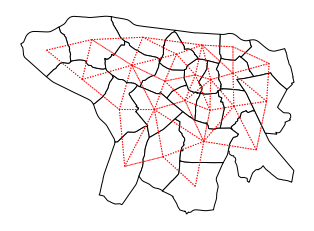

In [56]:
ax = distritos_ce.plot(edgecolor='k', facecolor='w')
wq.plot(distritos_ce, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

In [40]:
resumo['count_orders','mean2']  = weights.spatial_lag.lag_spatial(wq, resumo['count_orders']['mean'])

In [57]:
wq.transform = 'R'
moran = esda.moran.Moran(resumo['count_orders']['mean'] , wq)

In [67]:
print(f"Valor da estatística I de Moran: {round(moran.I , 4)}\np-valor:{moran.p_sim}")

Valor da estatística I de Moran: 0.5533
p-valor:0.001


---

---
#### Calculando medida de de autocorrelação espacial de Geary - Centro expandido

In [60]:
geary = esda.geary.Geary(resumo['count_orders']['mean'], wq)

In [66]:
print(f"Valor da estatística C de Geary: {round(geary.C , 4)}\np-valor:{geary.p_sim}")

Valor da estatística G de Geary: 0.4835
p-valor:0.001


In [62]:
geary.p_sim

0.001

---
## Criando dataframe de modelagem e variáveis necessárias <a name="criandodfmodelagem"> </a>

In [10]:
data = pd.DataFrame()

In [11]:
data['data'] = pd.date_range(start = '2019-06-23', end = '2019-10-14')
data['chave'] = 1

In [12]:
data['data'].shape

(114,)

In [13]:
data['data'].shape[0]*24

2736

In [14]:
pedidos_final_agg['data']= pedidos_final_agg['data'].astype('datetime64[ns]')

In [15]:
temp = pd.DataFrame( pedidos_final_agg['NOME_DIST'].unique(), columns = ['NOME_DIST'] )
temp['chave'] = 1
data = data.merge(temp , on = 'chave', how='left' )
data.drop(columns =['chave'] , inplace=True)
data = data.merge(pedidos_final_agg[['data','NOME_DIST','count_orders']] , on = ['data','NOME_DIST'], how='left' )

In [16]:
data.sort_values(by=['NOME_DIST','data'] , inplace = True)
data.reset_index(drop = True, inplace = True)

Mapa de missings da base antes da imputação. As regiões claras indicam registros com dados faltantes.

<AxesSubplot:>

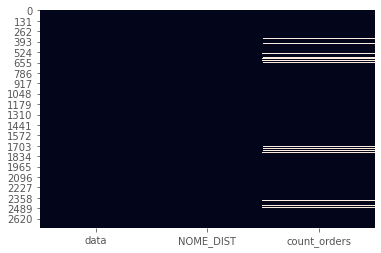

In [17]:
#Mapa de missings da base antes da imputação.
sns.heatmap(data.isnull(), cbar=False)

Frequência dos dados faltantes

In [315]:
data.isnull().sum()

data              0
NOME_DIST         0
count_orders    227
dtype: int64

In [317]:
#Porcentagem de missing
227/2736*100

8.296783625730994

### Realizando imputação com a moda de pedidos de cada distrito para os valores faltantes

In [18]:
for i in data['NOME_DIST'].unique():
    data.loc[(data['NOME_DIST'] == i) & ( data[data['NOME_DIST'] == i]['count_orders'].isnull() ) ,'count_orders'] = data[data['NOME_DIST'] == i]['count_orders'].value_counts().index[0]

Mapa de missings da base antes da imputação. As regiões claras indicam registros com dados faltantes.

<AxesSubplot:>

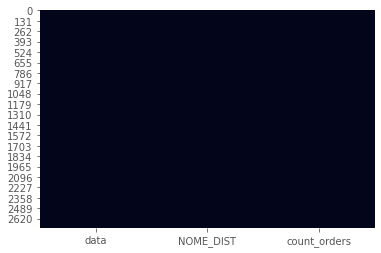

In [19]:
sns.heatmap(data.isnull(), cbar=False)

### Criando features

<font size="3">  - Features quantidade de pedidos da região defasado, de 1 ate 7 dias: </font>


In [20]:
for i in range(1,8):
    data['count_orders_'+ str(i) +'d'] = data.groupby('NOME_DIST')['count_orders'].shift(i)

<font size="3"> Feature Dia da semana: (Segunda=0, Domingo=6)
</font>

In [21]:
data['weekday'] = data['data'].dt.weekday

In [22]:
data = pd.concat( [data , pd.get_dummies( data['weekday'] , prefix='weekday') ], axis = 1)

<font size="3"> Flag Final de Semana
</font>

In [23]:
data['flag_weekend'] = 0
data.loc[ data['weekday'].isin([4,5,6]) , 'flag_weekend'] = 1

In [24]:
data.corr(method='pearson')

,count_orders,count_orders_1d,count_orders_2d,count_orders_3d,count_orders_4d,count_orders_5d,count_orders_6d,count_orders_7d,weekday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,flag_weekend
count_orders,1.000000,0.783139,0.759610,0.742157,0.740186,0.751955,0.784605,0.803297,0.090781,-0.076956,-0.045631,-0.017829,0.020734,0.087277,0.007820,0.025887,0.085351
count_orders_1d,0.783139,1.000000,0.782136,0.759858,0.741366,0.739046,0.750721,0.784150,0.060371,0.026310,-0.080975,-0.045622,-0.017664,0.021117,0.088036,0.008130,0.082718
count_orders_2d,0.759610,0.782136,1.000000,0.782780,0.759846,0.740580,0.737686,0.750322,0.052710,0.008778,0.023461,-0.080767,-0.045239,-0.017143,0.021830,0.089080,0.066303
count_orders_3d,0.742157,0.759858,0.782780,1.000000,0.783450,0.760379,0.740724,0.738239,-0.055923,0.089892,0.006681,0.023960,-0.080767,-0.045069,-0.016838,0.022320,-0.028066
count_orders_4d,0.740186,0.741366,0.759846,0.783450,1.000000,0.784878,0.758871,0.741726,-0.079948,0.024362,0.082462,0.008480,0.026019,-0.079882,-0.043784,-0.015236,-0.098746
count_orders_5d,0.751955,0.739046,0.740580,0.760379,0.784878,1.000000,0.784914,0.757786,-0.061913,-0.015494,0.026231,0.082718,0.008353,0.025977,-0.080478,-0.044191,-0.070355
count_orders_6d,0.784605,0.750721,0.737686,0.740724,0.758871,0.784914,1.000000,0.785047,-0.006121,-0.043897,-0.019905,0.027062,0.083997,0.009042,0.026832,-0.080474,-0.032130
count_orders_7d,0.803297,0.784150,0.750322,0.738239,0.741726,0.757786,0.785047,1.000000,0.092384,-0.081381,-0.042263,-0.020497,0.026695,0.083903,0.008589,0.026446,0.083914
weekday,0.090781,0.060371,0.052710,-0.055923,-0.079948,-0.061913,-0.006121,0.092384,1.000000,-0.621183,-0.399702,-0.199851,0.000000,0.199851,0.399702,0.621183,0.867641
weekday_0,-0.076956,0.026310,0.008778,0.089892,0.024362,-0.015494,-0.043897,-0.081381,-0.621183,1.000000,-0.169155,-0.169155,-0.169155,-0.169155,-0.169155,-0.175258,-0.363480


In [25]:
#Filtrando apenas os meses que serão usados para ajuste/treino dos modelos
data_model = data[ (data['data'].dt.month).isin( [7,8,9] ) ]

In [26]:
#Montagem da matriz de pesos aumentada para treino do SAR
distritos_ce = distritos_ce.sort_values(by='NOME_DIST').reset_index(drop=True )
wq = weights.contiguity.Queen.from_dataframe(distritos_ce)
wq.transform = 'R'

days = 92
matriz = {}
j=0
for j in range(0, max( wq.neighbors.keys() ) +1):
    for i in range(0 , days):
        matriz[ i + j * days ] = [ x * days + i for x in wq.neighbors[ j ] ]
        
wq_model2 = weights.W(matriz)
wq_model2.transform = 'R'

C:\Users\Herlisson\Anaconda3\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning: The weights matrix is not fully connected. There are 92 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


In [27]:
data_test = data[(data['data'] >= '2019-10-01') & (data['data'] <= '2019-10-07')].reset_index( drop = True )

In [28]:
data_valid = data[(data['data'] >= '2019-10-08') & (data['data'] <= '2019-10-14')].reset_index( drop = True )

Modelo teste de regressão linear comum

In [261]:
#Variaveis que serão utilizadas para treinar os modelos: seleção feita com filtro por corrleção
variable_names = [ 'count_orders_7d' ]

In [262]:
reg_OLS = spreg.OLS(data_model[['count_orders']].values, 
    data_model[variable_names].values,
    w=wq_model2, 
    name_y='count_orders', 
    name_x=variable_names
)
print(reg_OLS.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :count_orders                Number of Observations:        2208
Mean dependent var  :      6.9112                Number of Variables   :           2
S.D. dependent var  :      5.7524                Degrees of Freedom    :        2206
R-squared           :      0.6418
Adjusted R-squared  :      0.6417
Sum squared residual:   26156.431                F-statistic           :   3953.1390
Sigma-square        :      11.857                Prob(F-statistic)     :           0
S.E. of regression  :       3.443                Log likelihood        :   -5862.113
Sigma-square ML     :      11.846                Akaike info criterion :   11728.226
S.E of regression ML:      3.4418                Schwarz criterion     :   11739.626

-----------------------------------------------------------------------------

---
## Ajuste do modelo SAR <a name="ajuste-sar"></a>

In [263]:
reg2 = spreg.ML_Lag(
    data_model[['count_orders']].values, 
    data_model[variable_names].values,
    w=wq_model2, 
    name_y='count_orders', 
    name_x=variable_names
)
print(reg2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :count_orders                Number of Observations:        2208
Mean dependent var  :      6.9112                Number of Variables   :           3
S.D. dependent var  :      5.7524                Degrees of Freedom    :        2205
Pseudo R-squared    :      0.6632
Spatial Pseudo R-squared:  0.6572
Sigma-square ML     :      11.139                Log likelihood        :   -5805.009
S.E of regression   :       3.337                Akaike info criterion :   11616.018
                                                 Schwarz criterion     :   11633.118

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

Calculando a média histórica na base de treino para utilizar como baseline

In [837]:
preds_media_historica = data_model[['data','NOME_DIST']]
preds_media_historica['pred'] = data_model.mean()['count_orders']

Predicted Value
• predicted value from structural form is not valid
(assumes knowledge of Wy)

• $E[y | X] \neq \rho Wy + X$

Use reduced form instead:

• $E[y | X] = (I - \rho W)^{-1} X\beta $ 

In [274]:
def predict_sar( reg2 , data_test2 , variable_names , wq):
    wq_dim = len(wq.neighbors)
    data_test = data_test2.copy()
    data_test.sort_values(by = ['data','NOME_DIST'] , inplace = True)
    data_test.reset_index(drop=True , inplace = True)

    df_final = data_test[['data','NOME_DIST','count_orders']]

    for dt in df_final['data'].unique() :
        xb = np.matmul(pd.concat([pd.Series(np.ones( wq_dim )) , data_test[data_test['data'] == dt][variable_names].reset_index(drop=True) , pd.Series(np.ones(wq_dim)) ],axis=1 ).to_numpy(),reg2.betas  )
        #xb = np.matmul(pd.concat([pd.Series(np.ones(wq_dim)) , data_test[data_test['data'] == dt][variable_names].reset_index(drop=True) ],axis=1 ).to_numpy() , reg2.betas[:-1]  )
        pred = np.matmul( np.linalg.inv( np.identity( wq_dim ) - reg2.rho * wq.full()[0] ) , xb)

        df_final.loc[df_final['data'] == dt, 'pred'] = pred
        
    return df_final

In [265]:
def predict_ols( reg2 , data_test2 , variable_names , wq):
    wq_dim = len(wq.neighbors)
    data_test = data_test2.copy()
    data_test.sort_values(by = ['data','NOME_DIST'] , inplace = True)
    data_test.reset_index(drop=True , inplace = True)

    df_final = data_test[['data','NOME_DIST']]

    for dt in df_final['data'].unique() :
        #xb = np.matmul(pd.concat([pd.Series(np.ones( wq_dim )) , data_test[data_test['data'] == dt][variable_names].reset_index(drop=True) , pd.Series(np.ones(wq_dim)) ],axis=1 ).to_numpy(),reg2.betas  )
        pred = np.matmul(pd.concat([pd.Series(np.ones(wq_dim)) , data_test[data_test['data'] == dt][variable_names].reset_index(drop=True) ],axis=1 ).to_numpy() , reg2.betas  )

        df_final.loc[df_final['data'] == dt, 'pred'] = pred
        
    return df_final

In [840]:
preds_train_ols = predict_ols( reg_OLS , data_model , variable_names , wq ).sort_values(by=['NOME_DIST','data'])

In [841]:
preds_train_sar = predict_sar( reg2 , data_model , variable_names , wq ).sort_values(by=['NOME_DIST','data'])

In [95]:
mean_squared_error(data_model['count_orders'] , preds_train_ols['pred']) ** 0.5

3.4407870828051963

#### Calculo das métricas da avaliação <a name="desempenho-sar"></a>

Calculo do RMSE e R2 para base de treino

In [110]:
print(
f"""
Historic Mean RMSE: {round(mean_squared_error(data_model['count_orders'] , preds_media_historica['pred'])**0.5 , 3 ) }
Historic Mean R2: {round(r2_score(data_model['count_orders'] , preds_media_historica['pred']),3)} 
SAR RMSE: {round(mean_squared_error(data_model['count_orders'] , preds_train_sar['pred'])**0.5 , 3 ) }
SAR R2: {round(r2_score(data_model['count_orders'] , preds_train_sar['pred']),3)} 
OLS RMSE: {round( mean_squared_error(data_model['count_orders'] , preds_train_ols['pred'])**0.5 , 3 )}
OLS R2:  {round(r2_score(data_model['count_orders'] , preds_train_ols['pred']),3)}\n"""
     )


Historic Mean RMSE: 5.748
Historic Mean R2: 0.0 
SAR RMSE: 3.375
SAR R2: 0.655 
OLS RMSE: 3.441
OLS R2:  0.642



Calculo do RMSE e R2 para base de Teste

In [868]:
preds_test_media_historica = data_test[['data','NOME_DIST']]
preds_test_media_historica['pred'] = data_model.mean()['count_orders']

In [843]:
preds_test_ols = predict_ols( reg_OLS , data_test , variable_names , wq ).sort_values(by=['NOME_DIST','data']).reset_index(drop=True)
preds_test_sar = predict_sar( reg2 , data_test , variable_names , wq ).sort_values(by=['NOME_DIST','data']).reset_index(drop=True)

In [844]:
print(
f"""
Historic Mean RMSE: {round(mean_squared_error(data_test['count_orders'] , preds_test_media_historica['pred'])**0.5 , 4 ) }
Historic Mean R2: {round(r2_score(data_test['count_orders'] , preds_test_media_historica['pred']),4)} 
SAR RMSE: {round(mean_squared_error(data_test['count_orders'] , preds_test_sar['pred'])**0.5 , 3 ) }
SAR R2: {round(r2_score(data_test['count_orders'] , preds_test_sar['pred']),3)} 
OLS RMSE: {round( mean_squared_error(data_test['count_orders'] , preds_test_ols['pred'])**0.5 , 3 )}
OLS R2:  {round(r2_score(data_test['co/unt_orders'] , preds_test_ols['pred']),3)}\n"""
     )


Historic Mean RMSE: 5.5891
Historic Mean R2: -0.0032 
SAR RMSE: 3.125
SAR R2: 0.686 
OLS RMSE: 3.28
OLS R2:  0.655



In [120]:
print(
f"""
Historic Mean RMSE: {round(mean_squared_error(data_test['count_orders'] , preds_test_media_historica['pred'])**0.5 , 4 ) }
Historic Mean R2: {round(r2_score(data_test['count_orders'] , preds_test_media_historica['pred']),4)} 
SAR RMSE: {round(mean_squared_error(data_test['count_orders'] , preds_test_sar['pred'])**0.5 , 3 ) }
SAR R2: {round(r2_score(data_test['count_orders'] , preds_test_sar['pred']),3)} 
OLS RMSE: {round( mean_squared_error(data_test['count_orders'] , preds_test_ols['pred'])**0.5 , 3 )}
OLS R2:  {round(r2_score(data_test['count_orders'] , preds_test_ols['pred']),3)}\n"""
     )


Historic Mean RMSE: 5.5889
Historic Mean R2: -0.0031 
SAR RMSE: 3.126
SAR R2: 0.686 
OLS RMSE: 3.28
OLS R2:  0.655



In [869]:
preds_valid_media_historica = data_valid[['data','NOME_DIST','count_orders']]
preds_valid_media_historica['pred'] = data_model.mean()['count_orders']

In [275]:
preds_valid_ols = predict_ols( reg_OLS , data_valid , variable_names , wq ).sort_values( by=['NOME_DIST','data'] ).reset_index(drop=True)
preds_valid_sar = predict_sar( reg2 , data_valid , variable_names , wq ).sort_values(by=['NOME_DIST','data']).reset_index(drop=True)

In [873]:
print(
f"""
Historic Mean RMSE: {round(mean_squared_error(data_valid['count_orders'] , preds_valid_media_historica['pred'])**0.5 , 4 ) }
Historic Mean R2: {round(r2_score(data_valid['count_orders'] , preds_valid_media_historica['pred']),4)} 
SAR RMSE: {round(mean_squared_error(data_valid['count_orders'] , preds_valid_sar['pred'])**0.5 , 3 ) }
SAR R2: {round(r2_score(data_valid['count_orders'] , preds_valid_sar['pred']),3)} 
OLS RMSE: {round( mean_squared_error(data_valid['count_orders'] , preds_valid_ols['pred'])**0.5 , 3 )}
OLS R2:  {round(r2_score(data_valid['count_orders'] , preds_valid_ols['pred']),3)}\n"""
     )


Historic Mean RMSE: 6.5165
Historic Mean R2: -0.0173 
SAR RMSE: 3.604
SAR R2: 0.689 
OLS RMSE: 3.811
OLS R2:  0.652



---
### Primeiro modelo com RNA MLP <a name="ajuste-mlp"></a>

#### Organizando dataframe de treino: comum e aumentado

In [31]:
#Criando dataframe aumentado para treino
df_treino_mpl = data_model[['data','NOME_DIST','count_orders']+variable_names]
dfs_treino = {}

for i in wq.neighbors.keys():
    distrito_atual = distritos_ce[distritos_ce.index == i]['NOME_DIST'].values[0]

    df_aumentado_temp = df_treino_mpl[df_treino_mpl['NOME_DIST'] == distrito_atual].reset_index( drop = True )

    lista_vizinhos = wq.neighbors[i]
    for j in lista_vizinhos:
        df_aumentado_temp[ 'feature_n'+str(j) ] = df_treino_mpl[df_treino_mpl['NOME_DIST'] == distritos_ce[distritos_ce.index == j]['NOME_DIST'].values[0]]['count_orders_7d'].reset_index(drop=True)
        dfs_treino[i] = df_aumentado_temp

In [35]:
#Criando dataframe aumentado para teste
df_teste_mlp = data_test[['data','NOME_DIST','count_orders']+variable_names]
dfs_teste = {}

for i in wq.neighbors.keys():
    distrito_atual = distritos_ce[distritos_ce.index == i]['NOME_DIST'].values[0]

    df_aumentado_teste = df_teste_mlp[df_teste_mlp['NOME_DIST'] == distrito_atual].reset_index( drop = True )

    lista_vizinhos = wq.neighbors[i]
    for j in lista_vizinhos:
        df_aumentado_teste[ 'feature_n'+str(j) ] = df_teste_mlp[df_teste_mlp['NOME_DIST'] == distritos_ce[distritos_ce.index == j]['NOME_DIST'].values[0]]['count_orders_7d'].reset_index(drop=True)
        dfs_teste[i] = df_aumentado_teste

In [44]:
#Criando dataframe aumentado de validação
df_valid_mlp = data_valid[['data','NOME_DIST','count_orders']+variable_names]
dfs_valid= {}

for i in wq.neighbors.keys():
    distrito_atual = distritos_ce[distritos_ce.index == i]['NOME_DIST'].values[0]

    df_aumentado_valid = df_valid_mlp[df_valid_mlp['NOME_DIST'] == distrito_atual].reset_index( drop = True )

    lista_vizinhos = wq.neighbors[i]
    for j in lista_vizinhos:
        df_aumentado_valid[ 'feature_n'+str(j) ] = df_teste_mlp[df_teste_mlp['NOME_DIST'] == distritos_ce[distritos_ce.index == j]['NOME_DIST'].values[0]]['count_orders_7d'].reset_index(drop=True)
        dfs_valid[i] = df_aumentado_valid

In [200]:
#GridSearch para tunning
def GridSearch( df_treino , data_test , params ):
    
    resultados = {'params': [] ,
                  'rmse_test': [] ,
                  'r2_test' : [] ,
                  'r2_train': [],
                  'rmse_train': []}
    
    tot = len(ParameterGrid( params ))
    
    for i in ParameterGrid( params ):
        MLP = MLPRegressor()
        MLP.set_params( **i )
        
        x_train = df_treino.iloc[ :, 3: ]
        y_train = df_treino.iloc[ : , 2]

        MLP.fit(x_train , y_train)
        
        resultados['rmse_test'].append( mean_squared_error(data_test.iloc[:, 2] ,  MLP.predict( data_test.iloc[:, 3:] ) ) ** 0.5 )
        resultados['r2_test'].append( r2_score(data_test.iloc[:, 2] ,  MLP.predict( data_test.iloc[:, 3:] ) )  )
        resultados['rmse_train'].append( mean_squared_error(df_treino.iloc[:, 2] ,  MLP.predict( df_treino.iloc[:, 3:] ) ) ** 0.5 )
        resultados['r2_train'].append( r2_score(df_treino.iloc[:, 2] ,  MLP.predict( df_treino.iloc[:, 3:] ) )  )
        resultados['params'].append( i )
        
    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.sort_values(by = 'rmse_test')
    
    best_params = df_resultados.iloc[0,0]
    rmse = df_resultados.iloc[0,1]
    
    return best_params , rmse , df_resultados

In [102]:
#Ajustando os modelos MLP - Parametros fixos
modelos_MLP = {}

losses = []
test_performance = []
test_performance2 = []

for i in range(0, len(dfs_treino) ):
    
    df_treino = dfs_treino[i]

    MLP = MLPRegressor( hidden_layer_sizes=(6,6), activation='relu' , solver = 'lbfgs', max_fun=50, tol = 0.001,  random_state=42)
    

    x_train = df_treino.iloc[ :, 3: ]
    y_train = df_treino.iloc[ : , 2]

    MLP.fit(x_train , y_train)
    
    losses.append(mean_squared_error(dfs_teste[i].iloc[:, 2] ,  MLP.predict( dfs_teste[i].iloc[:, 3:] ) ) ** 0.5)
    test_performance.append( MLP.score(dfs_teste[i].iloc[:, 3:] , dfs_teste[i].iloc[:, 2]) )
    
    modelos_MLP[i] = MLP

In [299]:
#Ajustando os modelos MLP - Parametros tunados (refinados)
modelos_MLP_ref = {}

#losses = []
#test_performance = []
#test_performance2 = []
parametros_busca = { 'hidden_layer_sizes': [ (3) , (6) , (12) ,(3,3) , (6,6), (12,12) , (3,3,3) , (6,6,6), (12,12,12) ] ,
                     'activation': ['relu','logistic','tanh','identity'] , 
                    'solver': ['lbfgs'] ,
                    'alpha': [0.0001,0.001, 0.01, 0.05] ,
                    'max_fun': [10,50,100,200],
                    'random_state': [42]}

for i in range(0, len(dfs_treino) ):
    
    df_treino = dfs_treino[i]
    
    melhores_parametros , _ , _ = GridSearch( df_treino , dfs_teste[i] , parametros_busca)
    
    MLP = MLPRegressor()
    MLP.set_params( ** melhores_parametros )

    x_train = df_treino.iloc[ :, 3: ]
    y_train = df_treino.iloc[ : , 2]

    MLP.fit(x_train , y_train)
    
    #losses.append(mean_squared_error(dfs_teste[i].iloc[:, 2] ,  MLP.predict( dfs_teste[i].iloc[:, 3:] ) ) ** 0.5)
    #test_performance.append( MLP.score(dfs_teste[i].iloc[:, 3:] , dfs_teste[i].iloc[:, 2]) )
    
    modelos_MLP_ref[i] = MLP

In [92]:
def predict_mlp( modelos_MLP ,  dfs_teste , data_test):
    tam = len(modelos_MLP)
    
    df_pred = data_test.iloc[:,:3].reset_index(drop = True)
    
    for i in range(0 , tam):
        df_pred.loc[df_pred['NOME_DIST'] == dfs_teste[i]['NOME_DIST'][0] , 'pred'] = modelos_MLP[i].predict( dfs_teste[i].iloc[:,3:] )
        
    df_pred['erro'] = df_pred['count_orders'] - df_pred['pred']
    
    return df_pred

---
#### Métricas de avaliação MLP <a name="metricas-mlp"></a>

In [168]:
#Resultados MLP parametros fixos - base teste
preds_teste_mlp = predict_mlp( modelos_MLP ,  dfs_teste , data_test)
print( f"RMSE: {round( mean_squared_error( preds_teste_mlp['count_orders'] , preds_teste_mlp['pred'].round(0)  ) ** 0.5 ,3)}" )
print( f"R2: {round( r2_score( preds_teste_mlp['count_orders'] , preds_teste_mlp['pred'].round(0)  )  , 3 ) }" )

RMSE: 2.864
R2: 0.737


In [173]:
#Resultados MLP tunado - base teste
preds_teste_mlp_ref = predict_mlp( modelos_MLP_ref ,  dfs_teste , data_test)
print( f"RMSE: {round( mean_squared_error( preds_teste_mlp_ref['count_orders'] , preds_teste_mlp_ref['pred'].round(0)  ) ** 0.5 ,3)}" )
print( f"R2: {round( r2_score( preds_teste_mlp_ref['count_orders'] , preds_teste_mlp_ref['pred'].round(0)  ) , 3)}" )

RMSE: 2.272
R2: 0.834


In [172]:
#Resultados MLP parametros fixos - base validacao
preds_valid_mlp = predict_mlp( modelos_MLP ,  dfs_valid , data_valid)
print( f"RMSE: {round( mean_squared_error( preds_valid_mlp['count_orders'] , preds_valid_mlp['pred'].round(0)  ) ** 0.5 ,3)}" )
print( f"R2: {round( r2_score( preds_valid_mlp['count_orders'] , preds_valid_mlp['pred'].round(0)  )  , 3 ) }" )

RMSE: 3.51
R2: 0.705


In [208]:
#Resultados MLP tunado - base validacao
preds_valid_mlp_ref = predict_mlp( modelos_MLP_ref ,  dfs_valid , data_valid)
print( f"RMSE: {round( mean_squared_error( preds_valid_mlp_ref['count_orders'] , preds_valid_mlp_ref['pred'].round(0)  ) ** 0.5 ,3)}" )
print( f"R2: {round( r2_score( preds_valid_mlp_ref['count_orders'] , preds_valid_mlp_ref['pred'].round(0)  ) , 3)}" )

RMSE: 3.353
R2: 0.731


---
#### Calculando RMSE por distritos para cada um dos ajuste 

In [242]:
mapa_rmse_mlp = pd.DataFrame( preds_teste_mlp['NOME_DIST'].drop_duplicates().reset_index(drop=True) )
mapa_rmse_mlp['rmse'] =mapa_rmse_mlp['NOME_DIST'].apply(lambda x: mean_squared_error( preds_valid_mlp[preds_valid_mlp['NOME_DIST'] == x ]['count_orders'] , preds_valid_mlp[preds_valid_mlp['NOME_DIST'] == x ]['pred'])**0.5 )
print(mapa_rmse_mlp)

            NOME_DIST      rmse
0   ALTO DE PINHEIROS  2.466091
1         BARRA FUNDA  0.989911
2          BELA VISTA  3.312568
3               BELEM  0.977951
4          BOM RETIRO  0.957249
5                BRAS  1.134364
6             CAMBUCI  0.741105
7          CONSOLACAO  5.117722
8            IPIRANGA  2.286416
9          ITAIM BIBI  5.222867
10        JD PAULISTA  4.536328
11               LAPA  1.791917
12          LIBERDADE  3.489318
13              MOEMA  4.307500
14              MOOCA  2.762424
15               PARI  0.799505
16           PERDIZES  2.716124
17          PINHEIROS  3.975768
18          REPUBLICA  4.200319
19      SANTA CECILIA  3.729418
20              SAUDE  8.526737
21                 SE  0.892585
22    VILA LEOPOLDINA  1.628101
23       VILA MARIANA  3.982135


In [257]:
mapa_rmse_mlp_ref = pd.DataFrame( preds_valid_mlp['NOME_DIST'].drop_duplicates().reset_index(drop=True) )
mapa_rmse_mlp_ref['rmse'] =mapa_rmse_mlp['NOME_DIST'].apply(lambda x: mean_squared_error( preds_valid_mlp_ref[preds_valid_mlp_ref['NOME_DIST'] == x ]['count_orders'] , preds_valid_mlp_ref[preds_valid_mlp_ref['NOME_DIST'] == x ]['pred'])**0.5 )
print(mapa_rmse_mlp_ref)

            NOME_DIST      rmse
0   ALTO DE PINHEIROS  2.892815
1         BARRA FUNDA  1.625142
2          BELA VISTA  1.926883
3               BELEM  0.871010
4          BOM RETIRO  0.930188
5                BRAS  1.691790
6             CAMBUCI  1.144318
7          CONSOLACAO  6.677963
8            IPIRANGA  3.019997
9          ITAIM BIBI  4.976070
10        JD PAULISTA  4.787365
11               LAPA  1.872332
12          LIBERDADE  1.935917
13              MOEMA  4.205186
14              MOOCA  2.829291
15               PARI  0.767420
16           PERDIZES  2.856345
17          PINHEIROS  4.002512
18          REPUBLICA  4.067779
19      SANTA CECILIA  3.872613
20              SAUDE  6.728485
21                 SE  1.750382
22    VILA LEOPOLDINA  1.638887
23       VILA MARIANA  3.095107


In [276]:
mapa_rmse_sar = pd.DataFrame( preds_valid_sar['NOME_DIST'].drop_duplicates().reset_index(drop=True) )
mapa_rmse_sar['rmse'] =mapa_rmse_mlp['NOME_DIST'].apply(lambda x: mean_squared_error( preds_valid_sar[preds_valid_sar['NOME_DIST'] == x ]['count_orders'] , preds_valid_sar[preds_valid_sar['NOME_DIST'] == x ]['pred'])**0.5 )
print(mapa_rmse_sar)

            NOME_DIST      rmse
0   ALTO DE PINHEIROS  2.889082
1         BARRA FUNDA  1.508788
2          BELA VISTA  3.137711
3               BELEM  1.739328
4          BOM RETIRO  1.321169
5                BRAS  1.532619
6             CAMBUCI  2.263398
7          CONSOLACAO  7.260446
8            IPIRANGA  2.476754
9          ITAIM BIBI  3.983232
10        JD PAULISTA  4.959134
11               LAPA  1.573681
12          LIBERDADE  3.926060
13              MOEMA  4.118086
14              MOOCA  3.605200
15               PARI  1.261660
16           PERDIZES  2.344318
17          PINHEIROS  4.211854
18          REPUBLICA  3.265547
19      SANTA CECILIA  3.779001
20              SAUDE  6.160568
21                 SE  2.126870
22    VILA LEOPOLDINA  2.443624
23       VILA MARIANA  5.806676


In [296]:
mapa_rmse_mlp2 = distritos_ce.merge( mapa_rmse_mlp , how = 'left' , on = 'NOME_DIST')

In [244]:
mapa_rmse_mlp_ref2 = distritos_ce.merge( mapa_rmse_mlp_ref , how = 'left' , on = 'NOME_DIST')

In [277]:
mapa_rmse_sar2 = distritos_ce.merge(mapa_rmse_sar , how = 'left' , on = 'NOME_DIST')

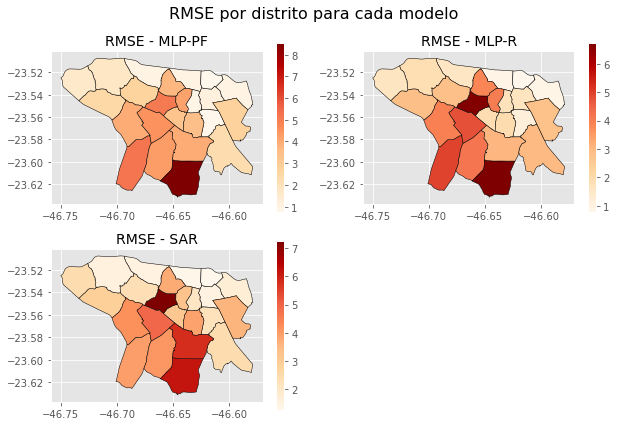

In [307]:
fig,ax = plt.subplots(2, 2, figsize=(9,6))
mapa_rmse_mlp2.plot('rmse' , legend=True , cmap='OrRd',ax=ax[0][0], edgecolor='black')
mapa_rmse_mlp_ref2.plot('rmse' , legend=True , cmap='OrRd',ax=ax[0][1], edgecolor='black')
mapa_rmse_sar2.plot('rmse' , legend=True , cmap='OrRd',ax=ax[1][0], edgecolor='black')

ax[0][0].set_title('RMSE - MLP-PF', fontsize=14)
ax[0][1].set_title('RMSE - MLP-R', fontsize=14)
ax[1][0].set_title('RMSE - SAR', fontsize=14)
#ax[0].axis('off')
ax[1][1].axis('off')
fig.suptitle("RMSE por distrito para cada modelo", fontsize=16)
plt.savefig('figura_rmse_por_distrito.png' , bbox_inches='tight')

fig.tight_layout()

---
### Previsão para o dia 15-10-2019 <a name="prev-15-10-2019"></a> 

In [358]:
data_pred = data_valid[data_valid['data'] == '2019-10-08'].iloc[:,:3].reset_index(drop=True)
data_pred['count_orders_7d'] = data_pred['count_orders'] 
data_pred['data'] = data_pred['data'] + pd.Timedelta(7,'days')

In [359]:
#Criando dataframe aumentado para predição do dia 15-10-2019
df_pred_mlp = data_pred[['data','NOME_DIST','count_orders']+variable_names]
dfs_pred= {}

for i in wq.neighbors.keys():
    distrito_atual = distritos_ce[distritos_ce.index == i]['NOME_DIST'].values[0]

    df_aumentado_pred = df_pred_mlp[df_pred_mlp['NOME_DIST'] == distrito_atual].reset_index( drop = True )

    lista_vizinhos = wq.neighbors[i]
    for j in lista_vizinhos:
        df_aumentado_pred[ 'feature_n'+str(j) ] = df_pred_mlp[df_pred_mlp['NOME_DIST'] == distritos_ce[distritos_ce.index == j]['NOME_DIST'].values[0]]['count_orders_7d'].reset_index(drop=True)
        dfs_pred[i] = df_aumentado_pred

In [360]:
data_pred['pred_MLP'] = round( predict_mlp(modelos_MLP , dfs_pred , df_pred_mlp )['pred'] , 0)
data_pred['pred_MLP_REF'] = round( predict_mlp(modelos_MLP_ref , dfs_pred , df_pred_mlp )['pred'] , 0)
data_pred['pred_SAR'] = round( predict_sar( reg2 , df_pred_mlp , variable_names , wq )['pred'] , 0 )

In [362]:
data_pred

,data,NOME_DIST,count_orders,count_orders_7d,pred_MLP,pred_MLP_REF,pred_SAR
0,2019-10-15,ALTO DE PINHEIROS,3.0,3.0,4.0,5.0,4.0
1,2019-10-15,BARRA FUNDA,2.0,2.0,3.0,4.0,3.0
2,2019-10-15,BELA VISTA,8.0,8.0,4.0,5.0,8.0
3,2019-10-15,BELEM,1.0,1.0,1.0,2.0,2.0
4,2019-10-15,BOM RETIRO,2.0,2.0,1.0,2.0,3.0
5,2019-10-15,BRAS,3.0,3.0,2.0,3.0,3.0
6,2019-10-15,CAMBUCI,1.0,1.0,2.0,1.0,2.0
7,2019-10-15,CONSOLACAO,11.0,11.0,10.0,13.0,10.0
8,2019-10-15,IPIRANGA,2.0,2.0,4.0,4.0,3.0
9,2019-10-15,ITAIM BIBI,12.0,12.0,18.0,16.0,12.0


In [376]:
data_pred2 = data_pred.copy()
data_pred2 = data_pred2.merge(pedidos_final_agg[['data' , 'NOME_DIST','count_orders']] , how='left' , on = ['data' , 'NOME_DIST'])
data_pred2.loc[15,'count_orders_y']=1

In [393]:
mean_squared_error( data_pred2['count_orders_y'] ,  data_pred2['pred_SAR'] )**0.5

2.6770630673681683

In [392]:
mean_squared_error( data_pred2['count_orders_y'] ,  data_pred2['pred_MLP'] )**0.5

1.9895560643855537

In [391]:
mean_squared_error( data_pred2['count_orders_y'] ,  data_pred2['pred_MLP_REF'] )**0.5

1.9472202409246537